# Experimenting With Custom Pod Autoscalers

In this notebook, we will be learning about how to experiment with Custom Pod
Autoscalers and log and plot different characteristics of the workload
along the way. 

In [127]:
master_ip = "192.168.23.88"

deploy_list = [
    #"redis-cart",
    #"shippingservice",
    #"paymentservice",
    # "productcatalogservice",
    #"emailservice",
    #"checkoutservice",
    #"recommendationservice",
    #"currencyservice",
    "cartservice"
    #"adservice",
    # "loadgenerator", # we don't want to scale load generator
    #"frontend",
]



In [128]:
from kubernetes import client, config
config.load_kube_config()

api_instance = client.AppsV1Api()

def get_replica_and_ready(deployment_name, deployment_ns="default"):
    api_response = api_instance.read_namespaced_deployment(deployment_name, deployment_ns)
    return api_response.status.replicas, api_response.status.ready_replicas

def set_replica_num(rnum, deployment_name, deployment_ns="default"):
    rnum = int(rnum)
    if rnum < 1:
        rnum = 1
    api_response = api_instance.read_namespaced_deployment(deployment_name, deployment_ns)
    api_response.spec.replicas = rnum
    api_instance.patch_namespaced_deployment_scale(deployment_name, deployment_ns, api_response)

def get_all_deployment_kubernetes_count():
    result = {}
    for d in deploy_list:
        counts = get_replica_and_ready(d)
        result[d + '_ordered'] = counts[0]
        result[d + '_ready'] = counts[1]
    return result

# Experiment With HPA vs CPA

To outline the difference between using a Custom Pod Autoscaler (CPA) and using the default Horizontal Pod Autoscaler (HPA),
we will be running a sample experiment with CPA and one with HPA. To enable/disable
HPA, use the `hpa_enabled` variable defined below:

In [129]:
import time

hpa_enabled = False

# scale everything to 1
for d in deploy_list:
    # !kubectl scale --replicas=1 deploy/{d}
    set_replica_num(1,d)
# making sure there is no hpa running
for d in deploy_list:
    !kubectl delete hpa/{d} > /dev/null 2>&1

if hpa_enabled:
    print('------> HPA Enabled!')
    for d in deploy_list:
        !kubectl autoscale deployment {d} --cpu-percent=50 --min=1 --max=10
    # wait to see if hpa will scale
    time.sleep(10)
    # wait until everything converges
    print('waiting for deployment to converge:')
    while min(get_all_deployment_kubernetes_count().values()) > 1:
        print('.', end='', flush=True)
        time.sleep(1)
    print('deployment converged')
else:
    print('------> HPA Disabled!')

------> HPA Disabled!


In [130]:
from pymongo import MongoClient
from bson.objectid import ObjectId

# Setting up Mongo DB
MONGO_HOST = '127.0.0.1'
MONGO_PORT = '27017'
MONGO_DB = 'cpa'
MONGO_USER = 'root'
MONGO_PASS = 'iRhrF6O0vp'

mongodb_client = MongoClient('mongodb://{}:{}@{}:{}/?authSource=admin'.format(MONGO_USER, MONGO_PASS, MONGO_HOST, MONGO_PORT))

cpa_db = mongodb_client[MONGO_DB]
loadtest_collection = cpa_db.loadtest

arr_results = []

for loadtest in loadtest_collection.find({ "_id": ObjectId("6083e47ca841517e81640f7d")}):
    arr_results = loadtest['data']
    break

In [131]:
import pandas as pd
import pacs_load_tester as load_tester

# create a folder for results
!mkdir -p results
# parse the results
results = None
for result in arr_results:
    df_result = pd.DataFrame(data=result)
    
    if results is None:
        results = df_result
    else:
        results = results.append(df_result)

# this is the base path for the locust server. don't change this value, just update master_ip on the top of the file.
locust_base = f"http://{master_ip}:8089/"

lt = load_tester.PACSLoadTester(hatch_rate=1000, temp_stat_max_len=60, base=locust_base)
results, filename = lt.prepare_results_from_df(results)
# get a list of columns
results.columns

Index(['time', 'current_response_time_percentile_50',
       'current_response_time_percentile_95', 'current_response_time_average',
       'current_max_response_time', 'current_min_response_time',
       'current_fail_per_sec', 'fail_ratio', 'total_rps', 'user_count',
       'avg_response_time', 'current_rps', 'max_response_time',
       'median_response_time', 'min_response_time', 'num_failures',
       'num_requests', 'custom_cpu_cartservice',
       'custom_monitored_count_cartservice',
       'custom_kubernetes_cartservice_ordered',
       'custom_kubernetes_cartservice_ready', 'elapsed', 'elapsed_min'],
      dtype='object')

## Plot The Results

Text(0, 0.5, 'Fail Per Second')

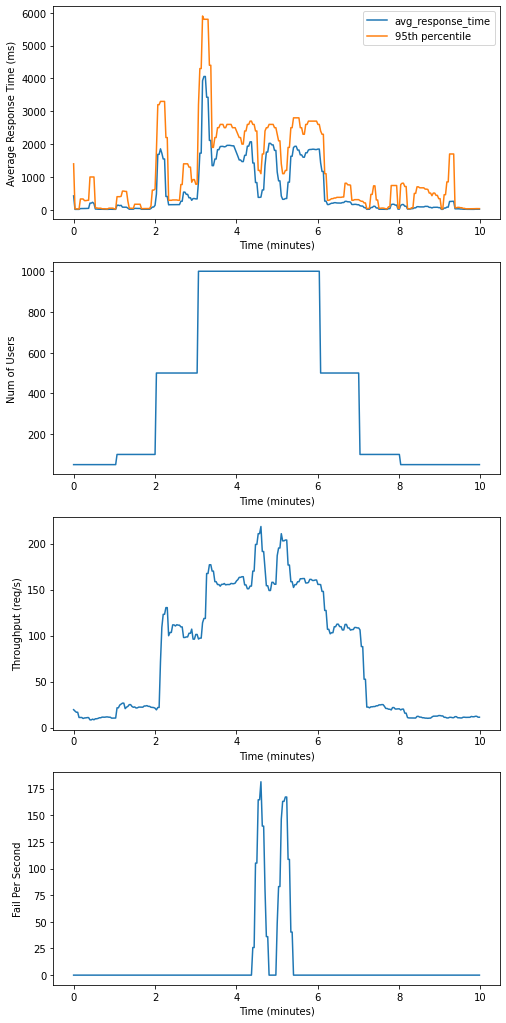

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

res = results

plt.figure(figsize=(8,18))
plt.subplot(411)
# plt.plot(res['elapsed_min'], res['current_min_response_time'], label='current_min_response_time')
# plt.plot(res['elapsed_min'], res['current_response_time_percentile_50'], label='median_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_average'], label='avg_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_percentile_95'], label='95th percentile')
# plt.plot(res['elapsed_min'], res['current_max_response_time'], label='current_max_response_time')

plt.xlabel('Time (minutes)')
plt.ylabel('Average Response Time (ms)')
plt.legend()

plt.subplot(412)
plt.plot(res['elapsed_min'], res['user_count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Num of Users')

plt.subplot(413)
plt.plot(res['elapsed_min'], res['total_rps'])
plt.xlabel('Time (minutes)')
plt.ylabel('Throughput (req/s)')

plt.subplot(414)
plt.plot(res['elapsed_min'], res['current_fail_per_sec'])
plt.xlabel('Time (minutes)')
plt.ylabel('Fail Per Second')

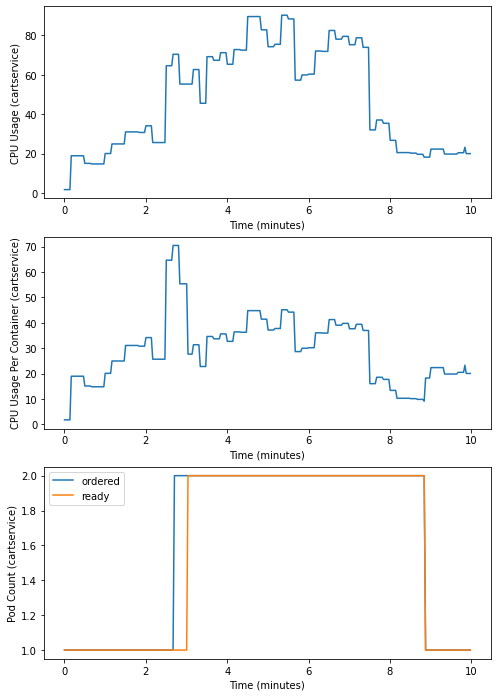

In [133]:
plot_deploy_list = [
    "cartservice"
]

for d in plot_deploy_list:
    plt.figure(figsize=(8, 12))
    plt.subplot(311)
    plt.plot(res['elapsed_min'], res[f'custom_cpu_{d}'])
    plt.xlabel('Time (minutes)')
    plt.ylabel(f'CPU Usage ({d})')
    plt.subplot(312)
    plt.plot(res['elapsed_min'], res[f'custom_cpu_{d}'] / res[f'custom_kubernetes_{d}_ready'])
    plt.xlabel('Time (minutes)')
    plt.ylabel(f'CPU Usage Per Container ({d})')
    plt.subplot(313)
    plt.plot(res['elapsed_min'], res[f'custom_kubernetes_{d}_ordered'], label='ordered')
    plt.plot(res['elapsed_min'], res[f'custom_kubernetes_{d}_ready'], label='ready')
    plt.xlabel('Time (minutes)')
    plt.ylabel(f'Pod Count ({d})')
    plt.legend()

In [118]:
# get the final status
!kubectl get deploy




NAME                             READY   UP-TO-DATE   AVAILABLE   AGE
mongodb                          1/1     1            1           12d
checkoutservice                  1/1     1            1           12h
redis-cart                       1/1     1            1           12h
currencyservice                  1/1     1            1           12h
shippingservice                  1/1     1            1           12h
paymentservice                   1/1     1            1           12h
emailservice                     1/1     1            1           12h
adservice                        1/1     1            1           12h
loadgenerator                    1/1     1            1           12h
cpa-frontend-deployment          1/1     1            1           3d2h
productcatalogservice            1/1     1            1           12h
frontend                         1/1     1            1           12h
cpa-api-deployment               1/1     1            1           12d
custom-pod-autoscal

In [119]:
!kubectl get hpa

No resources found in default namespace.
